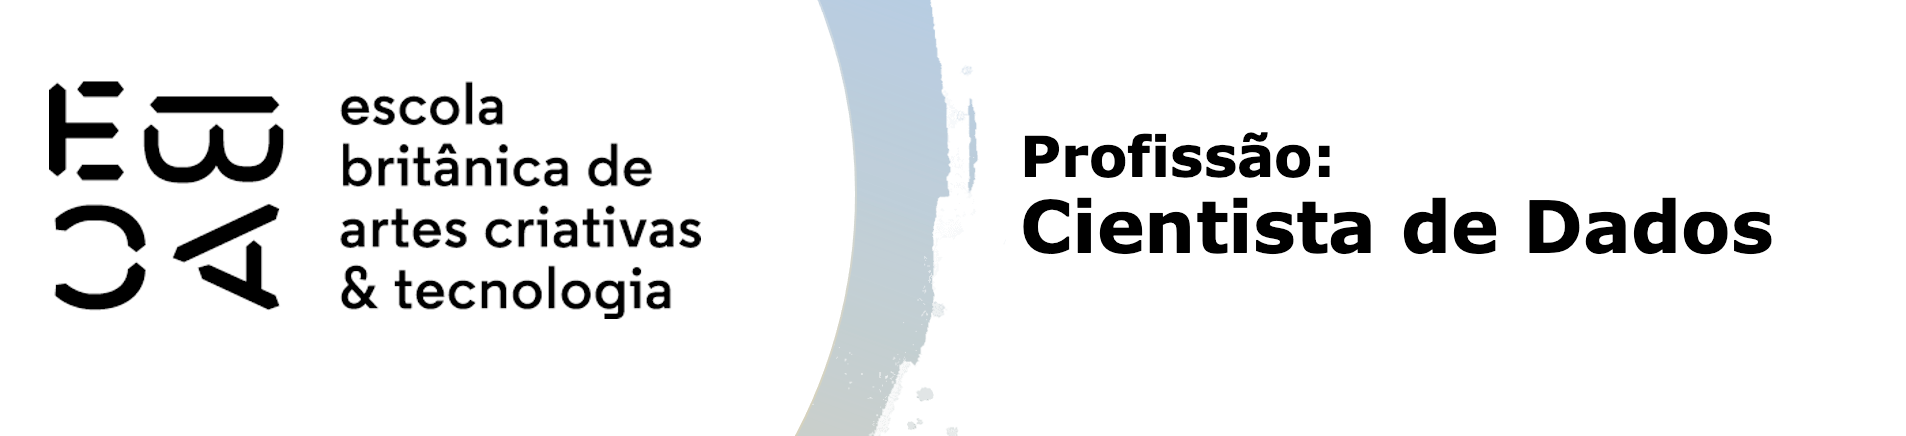

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from gower import gower_matrix
import gower

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import scipy

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
# Verificando valores faltantes
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

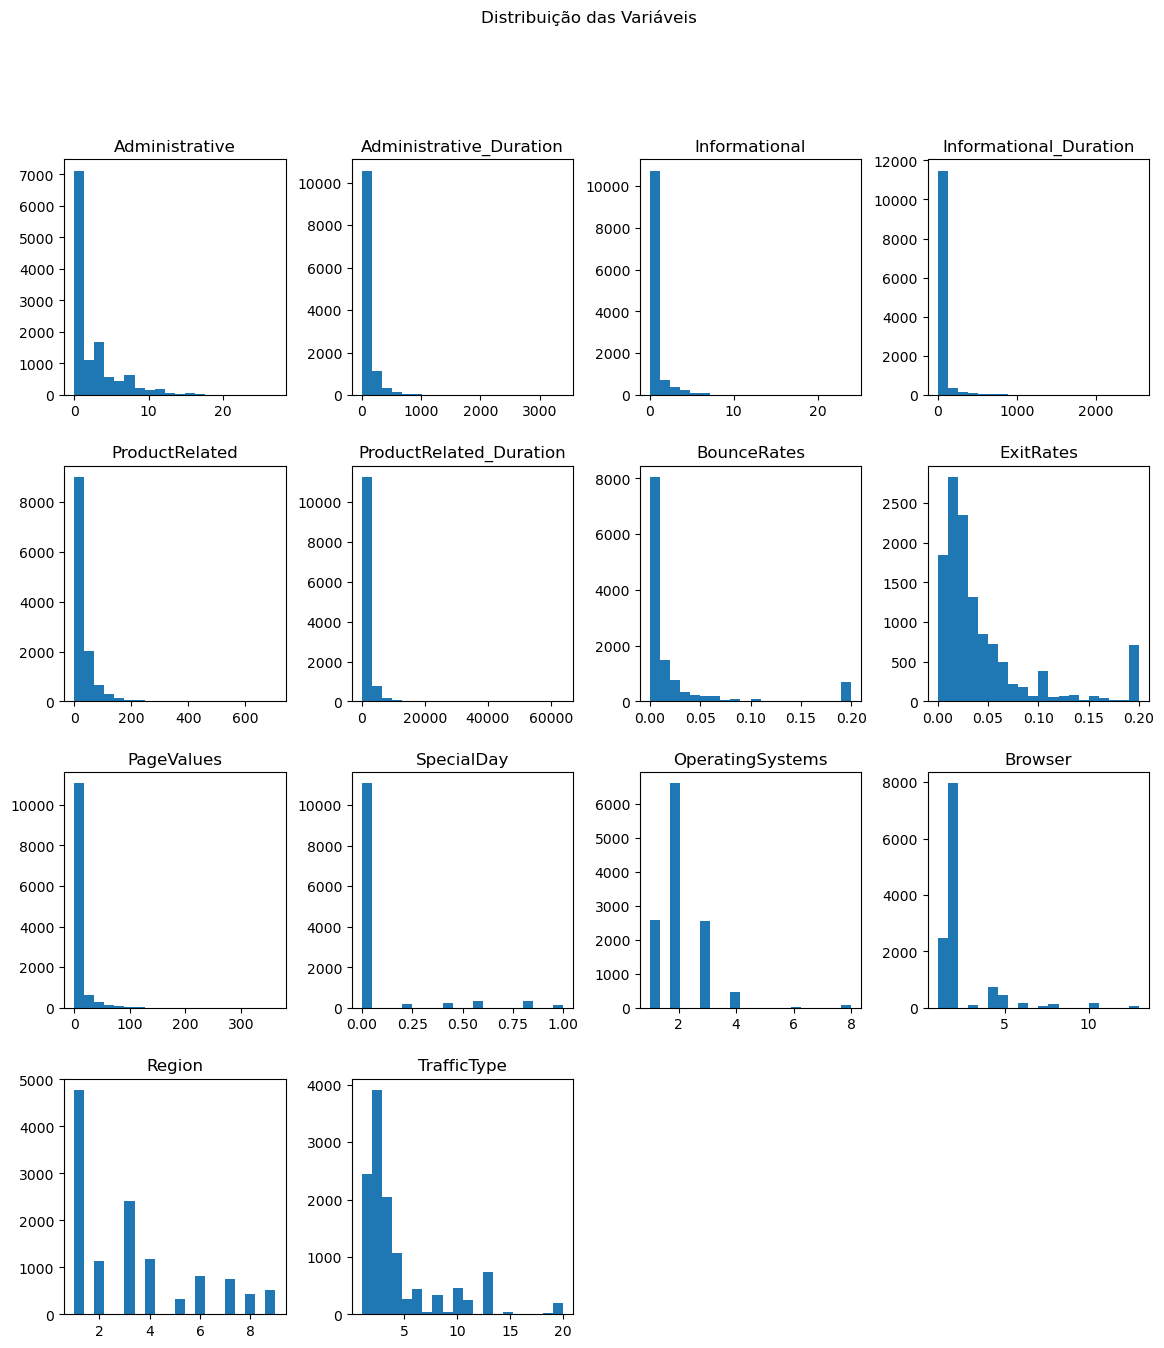

In [6]:
df.hist(figsize=(14, 15), bins=20, grid=False)
plt.suptitle("Distribuição das Variáveis")
plt.show()

#### A maioria das correlações com revenue foram moderadas ou fracas, as variáveis que tiveram correlações muito fracas vão ser retiradas pois além de ter a correlação fraca, também não fazem muito sentido de serem usadas.

#### Essas variáveis não vão ser usadas, pensei em usar o Weekend pois talvez faça sentido, mas pensando em compras online, realmente não depende tanto da pessoa ter disponibilidade de tempo, pois ela compra rapidamente em um celular ou pc.
<br>
Weekend                    0.029295
<br>
Browser                    0.023984
<br>
TrafficType               -0.005113
<br>
Region                    -0.011595
<br>
OperatingSystems          -0.014668

In [7]:
matriz_correlacao = df.corr()
correlacao_com_revenue = matriz_correlacao['Revenue'].sort_values(ascending=False)
print(correlacao_com_revenue)

Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Weekend                    0.029295
Browser                    0.023984
TrafficType               -0.005113
Region                    -0.011595
OperatingSystems          -0.014668
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue, dtype: float64


C:\Users\Bill_\AppData\Local\Temp\ipykernel_6884\3838242091.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacao = df.corr()


## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [8]:
# Criando novo DF apenas com as variáveis de escopo
df_escopo = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'Month', 'SpecialDay', 'PageValues', 'BounceRates', 'ExitRates']]
df_escopo

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Month,SpecialDay,PageValues,BounceRates,ExitRates
0,0,0.0,0,0.0,1,0.000000,Feb,0.0,0.000000,0.200000,0.200000
1,0,0.0,0,0.0,2,64.000000,Feb,0.0,0.000000,0.000000,0.100000
2,0,0.0,0,0.0,1,0.000000,Feb,0.0,0.000000,0.200000,0.200000
3,0,0.0,0,0.0,2,2.666667,Feb,0.0,0.000000,0.050000,0.140000
4,0,0.0,0,0.0,10,627.500000,Feb,0.0,0.000000,0.020000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,Dec,0.0,12.241717,0.007143,0.029031
12326,0,0.0,0,0.0,5,465.750000,Nov,0.0,0.000000,0.000000,0.021333
12327,0,0.0,0,0.0,6,184.250000,Nov,0.0,0.000000,0.083333,0.086667
12328,4,75.0,0,0.0,15,346.000000,Nov,0.0,0.000000,0.000000,0.021053


In [9]:
df_escopo.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
Month                       object
SpecialDay                 float64
PageValues                 float64
BounceRates                float64
ExitRates                  float64
dtype: object

In [10]:
df['Month'].unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [11]:
# Criando um dicionário para alterar a coluna month para inteiros
meses_para_numeros = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'June': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

# Mapeando a coluna month e alterando para inteiros de acordo com a lista
df_escopo['Month'] = df_escopo['Month'].map(meses_para_numeros)

df_escopo.dtypes

C:\Users\Bill_\AppData\Local\Temp\ipykernel_6884\481329972.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_escopo['Month'] = df_escopo['Month'].map(meses_para_numeros)


Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
Month                        int64
SpecialDay                 float64
PageValues                 float64
BounceRates                float64
ExitRates                  float64
dtype: object

#### Como esperado algumas variáveis tem correlação com as variáveis do mesmo tipo, como Administrative e Administrative_Duration, mas algumas correlações negativas também apareceram como Admistrative e ExitRates, Month e SpecialDay.

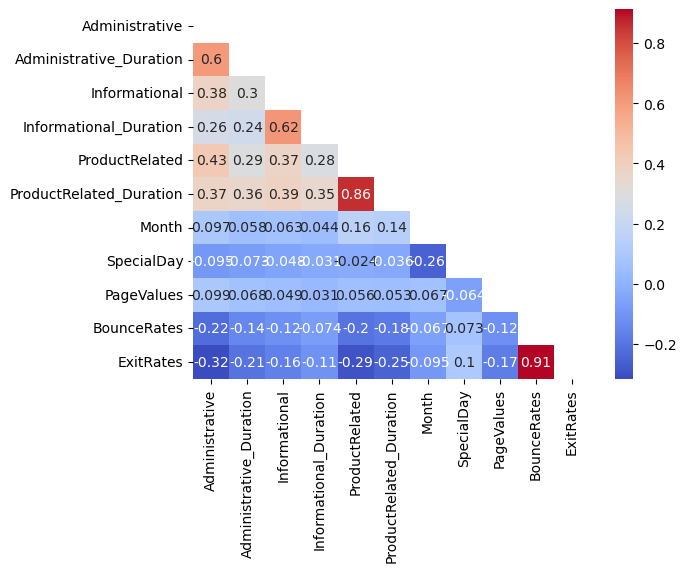

In [12]:
# Calcula a matriz de correlação
matriz_correlacao = df_escopo.corr()

# Cria uma máscara para esconder os valores repetidos e a correlação de uma variável consigo mesma
mascara = np.triu(np.ones_like(matriz_correlacao, dtype=bool))

# Plota a matriz de correlação sem os valores repetidos
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', mask=mascara)
plt.show()

#### Separando as features em numéricas e categóricas para poder trabalhar melhor com elas nas etapas seguintes.

In [13]:
categoricas = ['Administrative', 'Informational', 'ProductRelated', 'Month', 'SpecialDay']
numericas = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'PageValues', 'BounceRates', 'ExitRates']

In [14]:
# Fazendo uma lista de True para categóricas para aplicar na divisão da matriz gower
vars_cat = [True if x in categoricas else False for x in df_escopo.columns]
vars_cat

[True, False, True, False, True, False, True, True, False, False, False]

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

#### Fazendo a normalização dos valores numéricos continuos (não categóricos) para ficar com média 0 e desvio padrão 1.
<br>

#### Os dados categóricos não precisam ser transformados em dummies pois todos estão em formatos numéricos como padrão e o único que não estava que eram os meses foram transformados em numéricos também.

In [15]:
df_escopo_normalizado = df_escopo.copy() # Criando novo DF para salvar os valores normalizados

# Criando o objeto scaler para normalizar a média e desvio padrão
scaler = StandardScaler()

# Normalizando as colunas que tem valores numéricos continuos
df_escopo_normalizado[numericas] = scaler.fit_transform(df_escopo[numericas])

# print
df_escopo_normalizado

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Month,SpecialDay,PageValues,BounceRates,ExitRates
0,0,-0.457191,0,-0.244931,1,-0.624348,2,0.0,-0.317178,3.667189,3.229316
1,0,-0.457191,0,-0.244931,2,-0.590903,2,0.0,-0.317178,-0.457683,1.171473
2,0,-0.457191,0,-0.244931,1,-0.624348,2,0.0,-0.317178,3.667189,3.229316
3,0,-0.457191,0,-0.244931,2,-0.622954,2,0.0,-0.317178,0.573535,1.994610
4,0,-0.457191,0,-0.244931,10,-0.296430,2,0.0,-0.317178,-0.045196,0.142551
...,...,...,...,...,...,...,...,...,...,...,...
12325,3,0.363075,0,-0.244931,53,0.307822,12,0.0,0.342125,-0.310366,-0.288966
12326,0,-0.457191,0,-0.244931,5,-0.380957,11,0.0,-0.317178,-0.457683,-0.447364
12327,0,-0.457191,0,-0.244931,6,-0.528063,11,0.0,-0.317178,1.261014,0.897093
12328,4,-0.032916,0,-0.244931,15,-0.443536,11,0.0,-0.317178,-0.457683,-0.453140


In [16]:
# Calculando as distâncias gower, o segundo parâmetro é a lista de true ou false criada anteriormente, 
# onde True são as variáveis categóricas e false as numéricas
matriz_gower = gower_matrix(df_escopo_normalizado, cat_features = vars_cat)
matriz_gower

array([[0.        , 0.22736368, 0.        , ..., 0.28662547, 0.44747385,
        0.33336353],
       [0.22736368, 0.        , 0.22736368, ..., 0.22592846, 0.31101927,
        0.19703044],
       [0.        , 0.22736368, 0.        , ..., 0.28662547, 0.44747385,
        0.33336353],
       ...,
       [0.28662547, 0.22592846, 0.28662547, ..., 0.        , 0.25175747,
        0.13811041],
       [0.44747385, 0.31101927, 0.44747385, ..., 0.25175747, 0.        ,
        0.2050194 ],
       [0.33336353, 0.19703044, 0.33336353, ..., 0.13811041, 0.2050194 ,
        0.        ]], dtype=float32)

#### Rodei o squareform como visto em aula para que o algoritimo rodasse com mais eficiência na separação dos grupos, porém obtive alguns erros relacionados a diagonal principal não estar apenas com zeros, então precisei fazer algumas alterações para que esse erro fosse corrigido.

In [17]:
matriz_gower_scipy = scipy.sparse.csr_matrix(matriz_gower) # Transforma o gower para scipy
matriz_gower_scipy.setdiag(0) # Deixa a diagonal principal zerada
matriz_gower = matriz_gower_scipy.toarray() # transforma em array

gdv = squareform(matriz_gower, force='tovector') # Fazendo a transformação para o squareform
gdv

C:\Users\Bill_\anaconda3\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


array([0.22736368, 0.        , 0.18636742, ..., 0.25175747, 0.13811041,
       0.2050194 ], dtype=float32)

In [18]:
# Calculando a distância entre os clusters
Z = linkage(gdv, method = 'ward')
# Identificação dos clusters id1 e id2, dist é a distância entre os clusters e group o número de pontos no cluster formado
Z_df = pd.DataFrame(Z, columns=['id1', 'id2', 'dist', 'group'])
Z_df.head(20)

,id1,id2,dist,group
0,0.0,2.0,0.0,2.0
1,16.0,12330.0,0.0,3.0
2,6.0,79.0,0.0,2.0
3,2332.0,2513.0,0.0,2.0
4,4468.0,12333.0,0.0,3.0
5,24.0,12331.0,0.0,4.0
6,50.0,12335.0,0.0,5.0
7,3245.0,3818.0,0.0,2.0
8,4799.0,5378.0,0.0,2.0
9,2540.0,5279.0,0.0,2.0


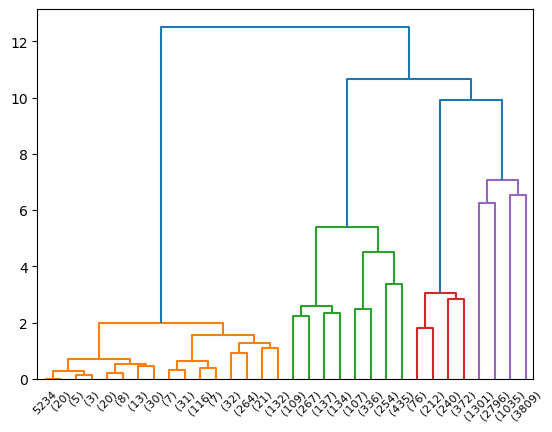

In [19]:
dendrogram(Z, truncate_mode='level', p=4)
plt.show()

#### Criando 2 DataFrames para analisar os grupos formados pelo Z(Linkage/ward) com 3 e 4 grupos.

In [20]:

df_4 = df_escopo.copy()
df_4['grupo'] = fcluster(Z, 4, criterion='maxclust')
df_4.grupo.value_counts()

4    8941
2    1779
3     900
1     710
Name: grupo, dtype: int64

In [21]:
df_3 = df_escopo.copy()
df_3['grupo'] = fcluster(Z, 3, criterion='maxclust')
df_3.grupo.value_counts()

3    9841
2    1779
1     710
Name: grupo, dtype: int64

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

#### Analisando os grupos pelas médias apresentadas é percebido que 3 grupos já são o suficiente para classificar os clientes até então, onde o primeiro grupo são pessoas que tendem a analisar melhor as informações e gastam mais tempo verificando o site e tem a maior taxa de compra, o terceiro grupo são pessoas que não pesquisam muito mas tem uma chance de comprar e o segundo grupo são o grupo que muito provavelmente não vão comprar e tem uma taxa de evasão muito alta.
<br>

#### Mesmo assim, o agrupamento com 4 grupos pode ser interessante para determinar o tipo de propaganda para mostrar para o grupo 1 ou grupo 2, pois o grupo 2 tem um valor de tempo nas paginas de informação muito mais elevada, talvez algo mais detalhado para o grupo 2 e uma página um pouco mais direto ao ponto e usando imagens para o grupo 1.

In [22]:
# Usando DataFrame de 3 grupos
grupos_caracteristicas = df_3.groupby('grupo').mean() # média dos valores agrupados por grupo
grupos_caracteristicas

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Month,SpecialDay,PageValues,BounceRates,ExitRates
grupo,,,,,,,,,,,
1,0.025352,0.022535,0.008451,0.000000,1.459155,10.346573,7.094366,0.047606,0.000000,0.195442,0.197744
2,4.599775,159.418383,2.242271,153.156986,63.421023,2465.769165,8.289488,0.042608,8.664103,0.007756,0.023465
3,2.067371,72.438996,0.224977,15.504358,28.186871,1050.428969,7.576974,0.065827,5.812530,0.012301,0.035458


In [23]:
# Usando DataFrame de 4 grupos
grupos_caracteristicas = df_4.groupby('grupo').mean() # média dos valores agrupados por grupo
grupos_caracteristicas

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Month,SpecialDay,PageValues,BounceRates,ExitRates
grupo,,,,,,,,,,,
1,0.025352,0.022535,0.008451,0.000000,1.459155,10.346573,7.094366,0.047606,0.000000,0.195442,0.197744
2,4.599775,159.418383,2.242271,153.156986,63.421023,2465.769165,8.289488,0.042608,8.664103,0.007756,0.023465
3,1.135556,34.616751,0.133333,8.487306,27.571111,911.385373,4.990000,0.620444,2.129730,0.029309,0.055628
4,2.161168,76.246179,0.234202,16.210694,28.248854,1064.425081,7.837378,0.009999,6.183240,0.010589,0.033428


#### Nos 2 blocos abaixo foram feitos DataFrames para comparar a coluna Revenue com os grupos, então foi criado um DataFrame para 3 e 4 grupos e incluido a coluna grupo nelas.

In [24]:
df_comparacao_3 = df.copy()
df_comparacao_3['grupo'] = df_3['grupo']

# Agrupando grupo e sexo
grupo_compra_3 = df_comparacao_3.groupby(['grupo', 'Revenue']).size().unstack().fillna(0)
grupo_compra_3

Revenue,False,True
grupo,,
1,707,3
2,1326,453
3,8389,1452


In [25]:

df_comparacao_4 = df.copy()
df_comparacao_4['grupo'] = df_4['grupo']

# Agrupando grupo e sexo
grupo_compra_4 = df_comparacao_4.groupby(['grupo', 'Revenue']).size().unstack().fillna(0)
grupo_compra_4

Revenue,False,True
grupo,,
1,707,3
2,1326,453
3,854,46
4,7535,1406


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

#### Para que tenha um maior detalhamento dos grupos, optei por ficar com 4 grupos, pois como dito anteriormente pode ajudar na separação de tipos de propaganda e o tratamento da página para esses diferentes tipos de clientes.
<br>

#### Compradores Sucintos
#### O primeiro grupo são pessoas um pouco mais direta ao ponto, vão gastar um pouco de tempo com páginas relacionadas ao produto mas não vão se aprofundar demais.
<br>

#### Compradores Pesquisadores
#### O segundo grupo vai ler todo site se possível, vai pesquisar bem sobre o que estão comprando e eles tem uma taxa de sucesso de compra um pouco maior que o grupo 1.
<br>

#### Perdidos
#### O terceiro grupo ou entraram no site sem querer ou entraram e não gostaram nem um pouco do que viram, eles tem a maior taxa de evasão do site e muito provavelmente não vão comprar nada.
<br>

#### Emocionados
#### O quarto grupo não vão ler nada, muito provavelmente vão comprar pela beleza do produto ou uma página bonita, vão ler o minimo do minimo, eles tem uma taxa muito menor que o grupo 1 e 2 (um terço de chance), mas ainda sim tem uma chance boa de compra.

#### Para fazer um melhor uso de Month e SpecialDay resolvi fazer mais algumas analises.

In [26]:
df_escopo['Revenue'] = df['Revenue']

C:\Users\Bill_\AppData\Local\Temp\ipykernel_6884\1609436759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_escopo['Revenue'] = df['Revenue']


#### Nos dois blocos a seguir mostra uma tabela com a quantidade de compras feitas ao longo dos meses e um gráfico sendo uma representação gráfica dessa tabela.

In [27]:
# Filtrando apenas as linhas com 'Revenue' igual a True
df_revenue_true = df_escopo[df_escopo['Revenue'] == True]

# Usando groupby para contar o número de True para cada mês
result_table_month = df_revenue_true.groupby('Month')['Revenue'].count().reset_index()

# Renomeando as colunas
result_table_month.columns = ['Month', 'Count_Revenue_True']
result_table_month

,Month,Count_Revenue_True
0,2,3
1,3,192
2,5,365
3,6,29
4,7,66
5,8,76
6,9,86
7,10,115
8,11,760
9,12,216


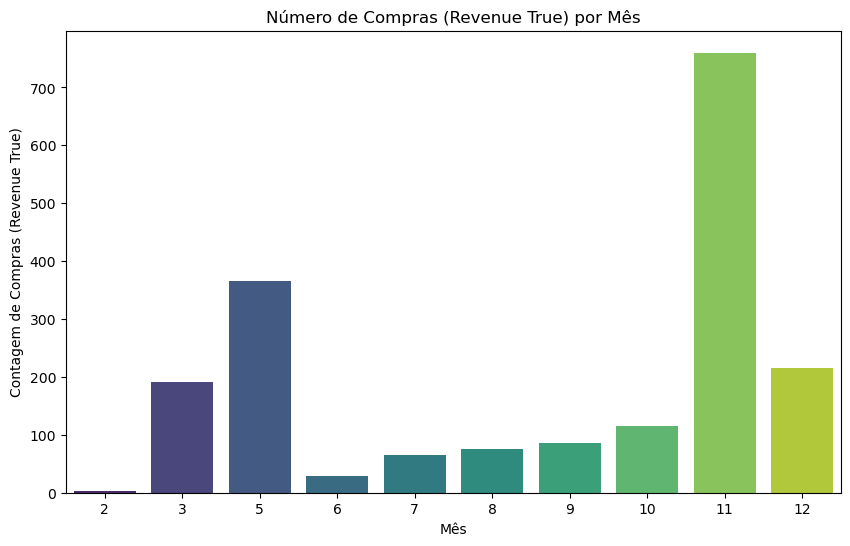

In [28]:
# Criando um gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Count_Revenue_True', data=result_table_month, palette='viridis')

# Adicionando rótulos e título
plt.xlabel('Mês')
plt.ylabel('Contagem de Compras (Revenue True)')
plt.title('Número de Compras (Revenue True) por Mês')

# Exibindo o gráfico
plt.show()

#### Não consegui associar muito bem SpecialDay a outras features, tem muitos valores 0.0 e o restante tem valores muito baixos tanto em número de compra quanto número de valores na coluna.

In [29]:
# Usando groupby para contar o número de True para cada valor de 'SpecialDay'
result_table_specialday = df_revenue_true.groupby('SpecialDay')['Revenue'].count().reset_index()

# Renomeando as colunas
result_table_specialday.columns = ['SpecialDay', 'Count_Revenue_True_SpecialDay']
result_table_specialday

,SpecialDay,Count_Revenue_True_SpecialDay
0,0.0,1831
1,0.2,14
2,0.4,13
3,0.6,29
4,0.8,11
5,1.0,10


In [30]:
# Obtendo a contagem de cada valor único na coluna 'SpecialDay'
specialday_counts = df_escopo['SpecialDay'].value_counts()

# Exibindo a contagem
specialday_counts

0.0    11079
0.6      351
0.8      325
0.4      243
0.2      178
1.0      154
Name: SpecialDay, dtype: int64